In [1]:
import pickle
import random
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential, model_from_json, load_model
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers.core import Dense, Activation, Flatten
from keras.layers import Dropout, Lambda, ELU
from os import listdir
import csv
import cv2
import json
import pandas as pd

%matplotlib inline
matplotlib.style.use('ggplot')

Using TensorFlow backend.


In [2]:
""" Global Constants """

DATA_DIR = 'data/'

class DrivingLogIndex:
    Center = 0
    Left = 1
    Right = 2
    Steering = 3
    Throttle = 4
    Brake = 5
    Speed = 6

STEERING_OFFSET = 0.3
IMG_WIDTH = 200
IMG_HEIGHT = 66
COLOR_IMG_DEPTH = 3
GRAY_IMG_DEPTH = 1

In [2]:
def load_data_from_log():
    with open('data/driving_log.csv', 'r') as f:
        log = list(csv.reader(f))
    return log[1:] # Remove header

In [3]:
driving_log = load_data_from_log()

driving_log = driving_log[1:] # Remove header

print(len(driving_log))
#print(driving_log['Center'][0])
#print(driving_log[1])
#print(driving_log[1][DrivingLogIndex.Center])

14788


In [5]:
""" Helper Methods"""
def get_image(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Crop the top 1/3 of the image
    img_shape = img.shape
    img = img[int(img_shape[0]/3):img_shape[0], 0:img_shape[1]]
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_AREA)
    return img    

def get_left_image(pos):
    img_path = '{}{}'.format(DATA_DIR, driving_log[pos][DrivingLogIndex.Left].strip())
    return get_image(img_path)

def get_right_image(pos):
    img_path = '{}{}'.format(DATA_DIR, driving_log[pos][DrivingLogIndex.Right].strip())
    return get_image(img_path)

def get_center_image(pos):
    img_path = '{}{}'.format(DATA_DIR, driving_log[pos][DrivingLogIndex.Center].strip())
    return get_image(img_path)

def get_left_steering(pos):
    return get_center_steering(pos) + STEERING_OFFSET

def get_right_steering(pos):
    return get_center_steering(pos) - STEERING_OFFSET

def get_center_steering(pos):
    return float(driving_log[pos][DrivingLogIndex.Steering])

(66, 200, 3)


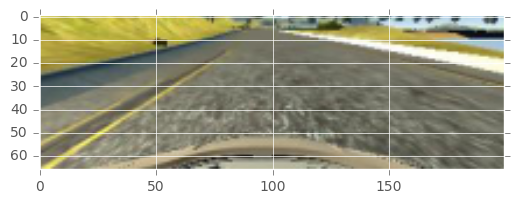

In [6]:
# Center image
tmp_center_img = get_center_image(2444)
print(tmp_center_img.shape)
plt.imshow(tmp_center_img)

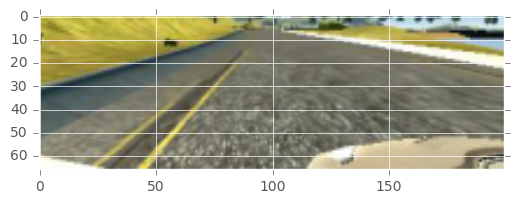

In [7]:
# Left image
tmp_left_img = get_left_image(2444)
plt.imshow(tmp_left_img)

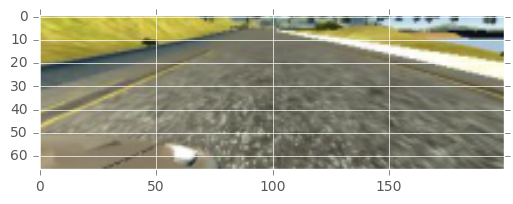

In [8]:
# Right image
tmp_right_img = get_right_image(2444)
plt.imshow(tmp_right_img)

(66, 200, 3)


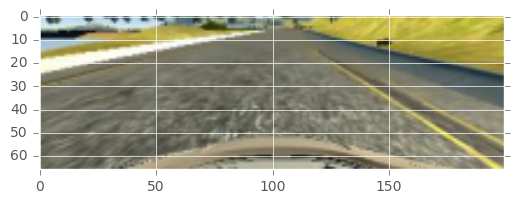

In [9]:
flipped = np.fliplr(tmp_center_img)
print(flipped.shape)
plt.imshow(flipped)

In [10]:
center_ret = get_center_steering(2444)
print('centersteering: {}'.format(center_ret))
left_ret = get_left_steering(2444)
print('left steering: {}'.format(left_ret))

centersteering: 0.0
left steering: 0.3


In [11]:
# Load training data from the driving_log file
def load_trainig_data():
    len_driving_log = len(driving_log)
    steps = 1 # center, left, right
    X_data = np.ndarray((len_driving_log * steps, IMG_HEIGHT, IMG_WIDTH, COLOR_IMG_DEPTH), dtype=np.uint8)
    y_data = np.ndarray((len_driving_log * steps), dtype=np.float32)
    
    # Load center, left and right images and steering data
    for i in range(0, len_driving_log):
        X_data[i] = get_center_image(i)
        y_data[i] = get_center_steering(i)
        #X_data[i+len_driving_log] = get_left_image(i)
        #y_data[i+len_driving_log] = get_left_steering(i)
        #X_data[i+len_driving_log*2] = get_right_image(i)
        #y_data[i+len_driving_log*2] = get_right_steering(i)        

    return (X_data, y_data)


In [12]:
X_data, y_data = load_trainig_data()
# Shuffle data
X_data, y_data = shuffle(X_data, y_data)

# Split data to train and validation set
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=0)
print('original data set: {}'.format(X_data.shape))
print('training data set: {}'.format(X_train.shape))
print('validation data set: {}'.format(X_val.shape))

original data set: (8034, 66, 200, 3)
training data set: (6427, 66, 200, 3)
validation data set: (1607, 66, 200, 3)


In [13]:
""" Image Utils"""
def batch_flip_left_right(X, y):
    X_result = np.zeros_like(X)
    y_result = np.zeros_like(y)
    for i in range(len(X)):
        X_result[i] = np.fliplr(X[i])
        y_result[i] = -1 * y[i]
    return X_result, y_result

def batch_generate_random_brightness(X):
    X_result = np.zeros_like(X)
    for i in range(len(X)):
        X_result[i] = get_random_brightness(X[i])
    return X_result

def batch_generate_random_shadow(X):
    X_result = np.array(X)
    for i in range(len(X_result)):
        X_result[i] = get_random_shadow_overlay(X_result[i])
    return X_result    

def get_random_brightness(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV) 
    random_light = 0.25 + np.random.uniform()
    hsv[:,:, 2] = hsv[:,:, 2] * random_light
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

def get_random_shadow_overlay(img):
    img_result = np.array(img)
    h, w = img_result.shape[0], img_result.shape[1]
    [x1, x2] = np.random.choice(w, 2, replace=False)
    k = h / (x2 - x1)
    b = -k * x1
    for i in range(h):
        c = int ((i - b) / k)
        img_result[i, :c, :] = (img_result[i, :c, :] * .5).astype(np.int32)
    return img_result

def shift_random_vertically(img):
    top = int(random.uniform(.075, .175) * img.shape[0])
    bottom = int(random.uniform(.075, .175) * img.shape[0])
    return img[top:-bottom, :]    

def jiggle_data(img, angle):
    # Reference: https://medium.com/@ValipourMojtaba/my-approach-for-project-3-2545578a9319#.xzwtzhnaa
    transRange = 100
    numPixels = 10
    valPixels = 0.4
    transX = transRange * np.random.uniform() - transRange/2
    angle_result = angle + transX/transRange * 2 * valPixels

    transY = numPixels * np.random.uniform() - numPixels/2
    transMat = np.float32([[1,0, transX], [0,1, transY]])
    img_result = cv2.warpAffine(img, transMat, (IMG_WIDTH, IMG_HEIGHT))
    return img_result, angle_result

0.0
0.14163102371
(66, 200, 3)


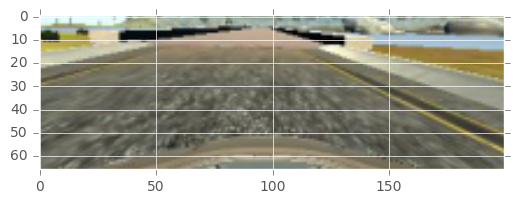

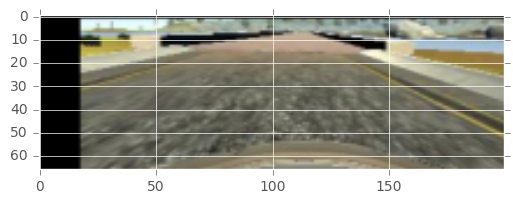

In [14]:
def test_jiggle_data():
    tmp_idx = np.random.randint(len(X_train) - 1)
    tmp_img = X_train[tmp_idx]
    
    plt.figure()
    plt.imshow(tmp_img)
    print(y_train[tmp_idx])
    
    tmp_img, tmp_angle = jiggle_data(X_train[tmp_idx], y_train[tmp_idx])
    plt.figure()
    plt.imshow(tmp_img)
    print(tmp_angle)
    print(tmp_img.shape)

test_jiggle_data()

(array([  3.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   2.00000000e+00,   2.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          2.00000000e+00,   1.30000000e+01,   1.00000000e+00,
          3.00000000e+00,   2.30000000e+01,   5.00000000e+00,
          1.70000000e+01,   1.30000000e+01,   1.00000000e+01,
          1.00000000e+01,   1.30000000e+01,   2.10000000e+01,
          6.70000000e+01,   3.30000000e+01,   1.90000000e+01,
          3.80000000e+01,   7.40000000e+01,   1.00000000e+01,
          2.90000000e+01,   7.20000000e+01,   1.89000000e+02,
          6.70000000e+01,   1.10000000e+02,   2.14000000e+02,
          1.75000000e+02,   7.00000000e+01,   6.80000000e+01,
        

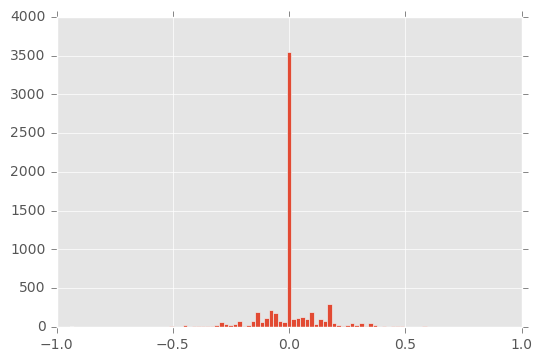

In [15]:
#steeringList
plt.hist(y_train, bins=100)

In [16]:
def generate_batch(X, y, batch_size=10):
    n = len(y)
    #keep_prob, start = 0.0, 0
    batch_count = n//batch_size
    X_result = np.zeros((batch_size, IMG_HEIGHT, IMG_WIDTH, COLOR_IMG_DEPTH))
    y_result = np.zeros(batch_size)
    while 1:
        counter = 0
        while counter <= batch_size - 1:
            idx = np.random.randint(n - 1)
            steering_angle = y[idx]
            img = get_center_image(idx)
            if np.random.rand() > 0.5: # 50% change to see the right angle
                img = cv2.flip(img, 1)
                steering_angle = -steering_angle
            
            # Randomly transpose image and steering angle
            img, steering_angle = jiggle_data(img, steering_angle)
            
            # Randomly adjust brightness
            img = get_random_brightness(img)
                        
            X_result[counter] = get_random_brightness(img)
            y_result[counter] = steering_angle
            
            counter += 1
        yield X_result, y_result
    
    
#temp_batch = train_generator(X_train, y_train, 10000, 10)
temp_batch = generate_batch(X_train, y_train, batch_size=100)

In [17]:
#imagesList = np.empty((0, IMG_HEIGHT, IMG_WIDTH, COLOR_IMG_DEPTH))
steeringList = np.empty((0))
for i in range(200):
    steeringList = np.append(steeringList, next(temp_batch)[1])


(array([   1.,    0.,    1.,    1.,    0.,    0.,    0.,    0.,    0.,
           0.,    1.,    0.,    2.,    2.,    0.,    1.,    4.,    3.,
           6.,    5.,    8.,   15.,   17.,   23.,   27.,   33.,   34.,
          35.,   56.,   84.,   87.,  107.,  116.,  144.,  288.,  518.,
         522.,  587.,  574.,  571.,  617.,  677.,  659.,  631.,  620.,
         659.,  677.,  650.,  692.,  648.,  631.,  642.,  677.,  714.,
         659.,  656.,  649.,  629.,  641.,  604.,  561.,  562.,  545.,
         545.,  162.,  124.,  117.,   88.,   95.,   58.,   36.,   40.,
          45.,   29.,   20.,   16.,   17.,    6.,    6.,    7.,    2.,
           4.,    1.,    1.,    0.,    1.,    1.,    0.,    1.,    0.,
           0.,    1.,    1.,    0.,    0.,    2.,    0.,    0.,    0.,    1.]),
 array([-1.34336409, -1.3161342 , -1.28890431, -1.26167442, -1.23444453,
        -1.20721464, -1.17998475, -1.15275487, -1.12552498, -1.09829509,
        -1.0710652 , -1.04383531, -1.01660542, -0.98937553, -0.9

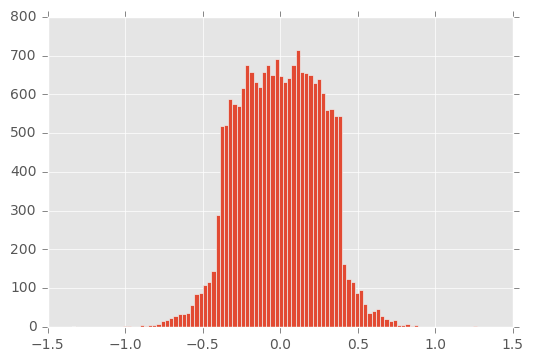

In [18]:
#steeringList
plt.hist(steeringList.astype('float'), bins=100)

In [19]:
# Build model
# Reference: http://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf
def nvidia_model():
    model = Sequential()

    # normalize image values between -.5 : .5
    model.add(Lambda(lambda x: x/255 - .5, input_shape=(IMG_HEIGHT, IMG_WIDTH, COLOR_IMG_DEPTH), \
                     output_shape=(IMG_HEIGHT, IMG_WIDTH, COLOR_IMG_DEPTH)))

    model.add(Convolution2D(24, 5, 5, subsample=(2, 2), border_mode='valid'))
    model.add(Activation('relu'))
    model.add(Convolution2D(36, 5, 5, subsample=(2, 2), border_mode='valid'))
    model.add(Activation('relu'))
    model.add(Convolution2D(48, 5, 5, subsample=(2, 2), border_mode='valid'))
    model.add(Activation('relu'))
    model.add(Convolution2D(64, 3, 3, subsample=(1, 1), border_mode='valid'))
    model.add(Activation('relu'))
    model.add(Convolution2D(64, 3, 3, subsample=(1, 1), border_mode='valid'))

    model.add(Flatten())
    model.add(Dropout(.5))
    model.add(Activation('relu'))

    model.add(Dense(100))
    model.add(Activation('relu'))

    model.add(Dense(50))
    model.add(Activation('relu'))

    model.add(Dense(10))
    model.add(Activation('relu'))

    model.add(Dense(1))

    model.compile(loss='mse', optimizer='adam')
    model.summary()
    return model

In [20]:
model = nvidia_model()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 66, 200, 3)    0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 31, 98, 24)    1824        lambda_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 31, 98, 24)    0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 14, 47, 36)    21636       activation_1[0][0]               
___________________________________________________________________________________________

In [21]:
def validation_generator(X, y, samples_per_epoch, batch_size):
    n = int(samples_per_epoch/batch_size)
    while 1:
        for i in range(n):
            start, end = i * batch_size, (i + 1) * batch_size
            yield(X[start:end], y[start:end])
    

In [22]:
iteration = 5
batch_size = 50
nb_epoch = 10
train_samples_per_epoch = len(X_train) - len(X_train) % batch_size
val_samples_per_epoch = len(X_val) - len(X_val) % batch_size
for i in range(iteration):
    print('Iteration {}'.format(i + 1))    
    train_generator = generate_batch(X_train, y_train, batch_size)
    valid_generator = validation_generator(X_val, y_val, val_samples_per_epoch, batch_size)
    model.fit_generator(train_generator, \
                        samples_per_epoch=train_samples_per_epoch, nb_epoch=nb_epoch, \
                        validation_data=valid_generator, \
                        nb_val_samples=train_samples_per_epoch)

Iteration 1
Epoch 1/10
6400/6400 [==============================] - 11s - loss: 0.0319 - val_loss: 0.0151
Epoch 2/10
6400/6400 [==============================] - 10s - loss: 0.0216 - val_loss: 0.0159
Epoch 3/10
6400/6400 [==============================] - 10s - loss: 0.0214 - val_loss: 0.0150
Epoch 4/10
6400/6400 [==============================] - 10s - loss: 0.0225 - val_loss: 0.0148
Epoch 5/10
6400/6400 [==============================] - 10s - loss: 0.0212 - val_loss: 0.0152
Epoch 6/10
6400/6400 [==============================] - 10s - loss: 0.0221 - val_loss: 0.0154
Epoch 7/10
6400/6400 [==============================] - 10s - loss: 0.0201 - val_loss: 0.0148
Epoch 8/10
6400/6400 [==============================] - 12s - loss: 0.0201 - val_loss: 0.0148
Epoch 9/10
6400/6400 [==============================] - 10s - loss: 0.0212 - val_loss: 0.0161
Epoch 10/10
6400/6400 [==============================] - 10s - loss: 0.0191 - val_loss: 0.0156
Iteration 2
Epoch 1/10
6400/6400 [=============

In [23]:
""" Save model """
with open('test.json', 'w') as f: 
    json.dump(model.to_json(), f)
model.save_weights('test.h5', True)    

In [ ]:
json_path = 'test.json'
with open(json_path, 'r') as f:
    model = model_from_json(json.load(f))
model.compile('adam', 'mse')
weights_path = json_path.replace('json', 'h5')
model.load_weights(weights_path)
    #
#model.load_weights('test.h5')